In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.interpolate import Rbf

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Read raw data from zeta-sizer, clean the data, calculate components ratio and average the measurements

In [2]:
df = pd.read_excel('data/dls_raw_combined_cleaned.xlsx')

In [3]:
df.head()

,record,type,sample,date,temp,z-aver,pdi,peak1_mean_int,peak2_mean_int,peak3_mean_int,...,c_dna_g_l,c_ha_g_l,record_zeta,type_zeta,sample_zeta,date_zeta,temp_zeta,zp,mob,cond
0,8,Size,0.25DNACHIT 1,11. huhtikuuta 2024 12:53:16,25.0,83.82,0.219,101.8,3121.0,0,...,0.122,0.0,5.0,Zeta,0.25DNACHIT 1,11. huhtikuuta 2024 12:39:12,25.0,-20.0,-0.9939,0.537
1,9,Size,0.25DNACHIT 2,11. huhtikuuta 2024 12:55:49,25.0,84.61,0.199,104.2,0.0,0,...,0.122,0.0,6.0,Zeta,0.25DNACHIT 2,11. huhtikuuta 2024 12:40:59,25.0,-21.5,-1.0650,0.562
2,10,Size,0.25DNACHIT 3,11. huhtikuuta 2024 12:58:22,25.0,85.40,0.210,100.5,5169.0,0,...,0.122,0.0,7.0,Zeta,0.25DNACHIT 3,11. huhtikuuta 2024 12:41:47,25.0,-25.1,-1.2480,0.574
3,14,Size,0.5DNACHIT 1,11. huhtikuuta 2024 13:28:35,25.0,93.75,0.148,112.1,0.0,0,...,0.108,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,Size,0.5DNACHIT 2,11. huhtikuuta 2024 13:30:37,25.0,92.29,0.141,107.5,0.0,0,...,0.108,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.columns


Index(['record', 'type', 'sample', 'date', 'temp', 'z-aver', 'pdi',
       'peak1_mean_int', 'peak2_mean_int', 'peak3_mean_int', 'peak1_area_int',
       'peak2_area_int', 'peak3_area_int', 'scattering_angle', 'c_sr3_g_l',
       'c_dna_g_l', 'c_ha_g_l', 'record_zeta', 'type_zeta', 'sample_zeta',
       'date_zeta', 'temp_zeta', 'zp', 'mob', 'cond'],
      dtype='object')

### Features descriptions
'record': instrument internal number of record   
'type': typle of measurement   
'sample': sample name with measurement repetition number   
'date': measurement date  
'temp': temperature, C   
'z-aver': Z-average diameter (Cumulant expansion)   
'pdi': polydispersity (Cumulant expansion)   
'peak_mean_int': peak max intensity (CONTIN)    
'peak_area_int': peak area (CONTIN)   
'scattering_angle': laser scattering angle   
'c_sr3_g_l': concentration of trimethylammoniumbenzyl-chitosan (T-CS) before mixing, g/L   
'c_dna_g_l': concentration of DNA oligos before mixing, g/L    
'c_ha_g_l': concentration of hyaluronic acid (HA) before mixing, g/L   
'record_zeta':zeta-potential measurement record   
'type_zeta': type of measurement   
'sample_zeta': sample name (zeta)   
'date_zeta': date of zeta-potential measurement   
'temp_zeta': temperature, C   
'zp': zeta-potential, mV   
'mob': electrophoretic mobility   
'cond': conductivity   

### Description of calculated features
'cs_dna_mass': T-CS:DNA mass ratio   
'ha_cs_mass': HA:T-CS mass ratio   
'np': N(T-CS):P(DNA) molar ratio   
'ha_cs_nn': N(HA):N(T-CS) molar ratio   
'min_plus_ratio': molar ratio of total negative groups to positive groups

In [5]:
#add columns for components ratio and calculation of molar ratios
df['cs_dna_mass'] = df['c_sr3_g_l']/df['c_dna_g_l']
df['ha_cs_mass'] = df['c_ha_g_l']/df['c_sr3_g_l']
df['np'] = df['cs_dna_mass']*1.66
df['ha_cs_nn']=df['ha_cs_mass']/2.35
df['min_plus_ratio']=df['c_dna_g_l']/df['c_sr3_g_l']/1.66+df['ha_cs_mass']/2.35
df.head()

,record,type,sample,date,temp,z-aver,pdi,peak1_mean_int,peak2_mean_int,peak3_mean_int,...,date_zeta,temp_zeta,zp,mob,cond,cs_dna_mass,ha_cs_mass,np,ha_cs_nn,min_plus_ratio
0,8,Size,0.25DNACHIT 1,11. huhtikuuta 2024 12:53:16,25.0,83.82,0.219,101.8,3121.0,0,...,11. huhtikuuta 2024 12:39:12,25.0,-20.0,-0.9939,0.537,0.150000,0.0,0.249000,0.0,4.016064
1,9,Size,0.25DNACHIT 2,11. huhtikuuta 2024 12:55:49,25.0,84.61,0.199,104.2,0.0,0,...,11. huhtikuuta 2024 12:40:59,25.0,-21.5,-1.0650,0.562,0.150000,0.0,0.249000,0.0,4.016064
2,10,Size,0.25DNACHIT 3,11. huhtikuuta 2024 12:58:22,25.0,85.40,0.210,100.5,5169.0,0,...,11. huhtikuuta 2024 12:41:47,25.0,-25.1,-1.2480,0.574,0.150000,0.0,0.249000,0.0,4.016064
3,14,Size,0.5DNACHIT 1,11. huhtikuuta 2024 13:28:35,25.0,93.75,0.148,112.1,0.0,0,...,NaN,NaN,NaN,NaN,NaN,0.299074,0.0,0.496463,0.0,2.014249
4,15,Size,0.5DNACHIT 2,11. huhtikuuta 2024 13:30:37,25.0,92.29,0.141,107.5,0.0,0,...,NaN,NaN,NaN,NaN,NaN,0.299074,0.0,0.496463,0.0,2.014249


### Cut unnecessary columns   
Select columns for convenience

In [6]:
df = df[['sample', 'z-aver', 'c_sr3_g_l', 'c_dna_g_l', 'c_ha_g_l', 'zp', 'cs_dna_mass', 'ha_cs_mass', 'np', 'ha_cs_nn', 'min_plus_ratio']]

In [7]:
df

,sample,z-aver,c_sr3_g_l,c_dna_g_l,c_ha_g_l,zp,cs_dna_mass,ha_cs_mass,np,ha_cs_nn,min_plus_ratio
0,0.25DNACHIT 1,83.82,0.0183,0.122,0.00,-20.00,0.150000,0.0,0.249000,0.000000,4.016064
1,0.25DNACHIT 2,84.61,0.0183,0.122,0.00,-21.50,0.150000,0.0,0.249000,0.000000,4.016064
2,0.25DNACHIT 3,85.40,0.0183,0.122,0.00,-25.10,0.150000,0.0,0.249000,0.000000,4.016064
3,0.5DNACHIT 1,93.75,0.0323,0.108,0.00,NaN,0.299074,0.0,0.496463,0.000000,2.014249
4,0.5DNACHIT 2,92.29,0.0323,0.108,0.00,NaN,0.299074,0.0,0.496463,0.000000,2.014249
...,...,...,...,...,...,...,...,...,...,...,...
121,3(6.5) 2,189.40,0.1000,0.010,0.25,15.40,10.000000,2.5,16.600000,1.063830,1.124071
122,3(6.5) 3,189.30,0.1000,0.010,0.25,17.10,10.000000,2.5,16.600000,1.063830,1.124071
123,4(6.5) 1,3487.00,0.1000,0.010,0.05,4.87,10.000000,0.5,16.600000,0.212766,0.273007
124,4(6.5) 2,3100.00,0.1000,0.010,0.05,5.14,10.000000,0.5,16.600000,0.212766,0.273007


In [8]:
df['sample'] = df['sample'].str.slice(0, -2).copy() #remove the measurement number
df = df.groupby('sample').mean().copy().reset_index() # Average the measurements

In [9]:
df.head()

,sample,z-aver,c_sr3_g_l,c_dna_g_l,c_ha_g_l,zp,cs_dna_mass,ha_cs_mass,np,ha_cs_nn,min_plus_ratio
0,0.25DNACHIT,84.610000,0.0183,0.122,0.0000,-22.200000,0.150000,0.000000,0.249000,0.000000,4.016064
1,0.25HASR3,231.200000,0.0440,0.000,0.0259,14.733333,NaN,0.588636,NaN,0.250484,0.250484
2,0.5DNACHIT,93.090000,0.0323,0.108,0.0000,NaN,0.299074,0.000000,0.496463,0.000000,2.014249
3,0.5HASR3,221.033333,0.0322,0.000,0.0378,8.856667,NaN,1.173913,NaN,0.499537,0.499537
4,1(3.5),159.100000,0.1000,0.040,0.0000,16.566667,2.500000,0.000000,4.150000,0.000000,0.240964


In [10]:
# add particle type feature according to concentrations of components
df['particle_type'] = df.apply(lambda x: 'cs_ha' if x['c_dna_g_l'] == 0 else ('cs_dna' if x['c_ha_g_l'] == 0 else 'cs_ha_dna'), axis = 1)

In [ ]:
df.to_excel("output/dls_supplementary.xlsx")

### Making plots   
Plotting how zeta-potential and hydrodynamic diameter changes with ionizable group ratio.   
Then 3d plots of zeta-potential and hydrodynamic diameter vs components ratios.

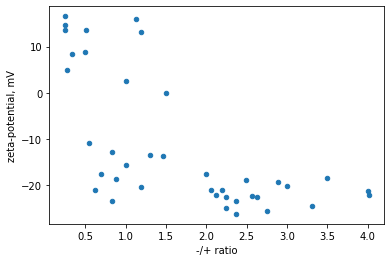

In [13]:
#Zeta-ppotential vs. charge ratio
df.plot.scatter('min_plus_ratio', 'zp')
plt.xlabel('-/+ ratio')
plt.ylabel('zeta-potential, mV')
plt.show()

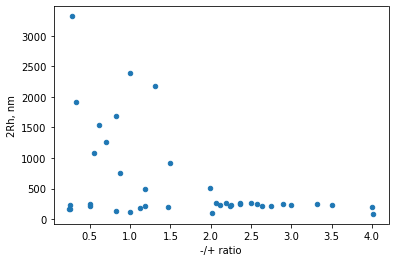

In [15]:
#Size vs. charge ratio
df.plot.scatter('min_plus_ratio', 'z-aver')
plt.xlabel('-/+ ratio')
plt.ylabel('2Rh, nm')
plt.show()

In [ ]:
df.to_csv('out.csv', sep=';', encoding='utf-8')

In [16]:
#Select polyplexes with three components for 3d plots
df = df.query('c_dna_g_l > 0 and c_ha_g_l > 0')

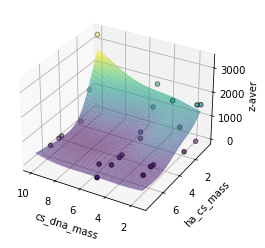

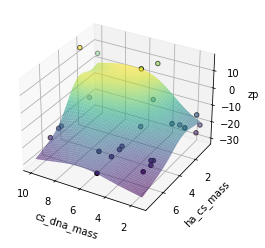

In [17]:
# Extract the columns into numpy arrays
x = df['cs_dna_mass'].values
y = df['ha_cs_mass'].values
z = df['z-aver'].values

# Create a grid to evaluate the RBF
xi = np.linspace(min(x), max(x), 200)
yi = np.linspace(min(y), max(y), 200)
xi, yi = np.meshgrid(xi, yi)

# Fit RBF
rbf = Rbf(x, y, z, function='multiquadric', smooth=0.3)
zi = rbf(xi, yi)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(xi, yi, zi, cmap='viridis', alpha=0.6)

# Plot the original points
ax.scatter(x, y, z,  c=z, cmap='viridis', edgecolor='k')

# Set the view angle
ax.view_init(elev=30, azim=120)

# Labeling the axes
ax.set_xlabel('cs_dna_mass')
ax.set_ylabel('ha_cs_mass')
ax.set_zlabel('z-aver')

plt.show()

# Second plot with 'zp' as z-axis
z2 = df['zp'].values

# Fit RBF for the second plot
rbf2 = Rbf(x, y, z2, function='multiquadric', smooth=0.3)
zi2 = rbf2(xi, yi)

# Create the second plot
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')

# Plot the surface
ax2.plot_surface(xi, yi, zi2, cmap='viridis', alpha=0.6)

# Plot the original points
ax2.scatter(x, y, z2, c=z2, cmap='viridis', edgecolor='k')

# Set the view angle
ax2.view_init(elev=30, azim=120)

# Labeling the axes
ax2.set_xlabel('cs_dna_mass')
ax2.set_ylabel('ha_cs_mass')
ax2.set_zlabel('zp')

plt.show()


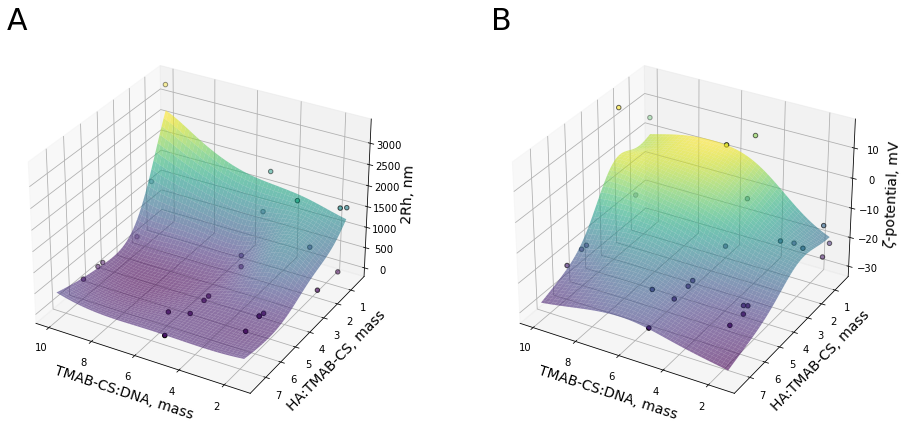

In [19]:
x = df['cs_dna_mass'].values
y = df['ha_cs_mass'].values

# First plot with 'z-aver' as z-axis
z1 = df['z-aver'].values

# Create a grid to evaluate the RBF
xi = np.linspace(min(x), max(x), 200)
yi = np.linspace(min(y), max(y), 200)
xi, yi = np.meshgrid(xi, yi)

# Fit RBF for the first plot
rbf1 = Rbf(x, y, z1, function='multiquadric', smooth=0.3)
zi1 = rbf1(xi, yi)

# Second plot with 'zp' as z-axis
z2 = df['zp'].values

# Fit RBF for the second plot
rbf2 = Rbf(x, y, z2, function='multiquadric', smooth=0.3)
zi2 = rbf2(xi, yi)

# Create the figure and subplots
fig = plt.figure(figsize=(14, 6))

# First subplot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(xi, yi, zi1, cmap='viridis', alpha=0.6)
ax1.scatter(x, y, z1, c=z1, cmap='viridis', edgecolor='k')
ax1.view_init(elev=30, azim=120)
ax1.set_xlabel('TMAB-CS:DNA, mass', fontsize = 14)
ax1.set_ylabel('HA:TMAB-CS, mass', fontsize = 14)
ax1.set_zlabel('2Rh, nm', fontsize = 14)
ax1.set_title('A', loc='left', fontsize = 30)

# Second subplot
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(xi, yi, zi2, cmap='viridis', alpha=0.6)
ax2.scatter(x, y, z2, c=z2, cmap='viridis', edgecolor='k')
ax2.view_init(elev=30, azim=120)
ax2.set_xlabel('TMAB-CS:DNA, mass', fontsize = 14)
ax2.set_ylabel('HA:TMAB-CS, mass', fontsize = 14)
ax2.set_zlabel('$\zeta$-potential, mV', fontsize = 14)
ax2.set_title('B', loc='left', fontsize = 30)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.savefig('output/3dplots.png', facecolor='white')

### Discussion   

To assess the influence of the ratio of components on the size and ζ-potential of polyplexes, we varied the ratio and fixed the total concentration of T-CS to 0.1 g/L (Figure 2). The goal of the experiment was to explore how the characteristics of DNA:T-CS:HA polyplexes change over a wide range of components ratios. Zeta-potential ranged from -26 to 16 mV and followed a tendency to decrease with increasing HA amount and to increase with increasing T-CS amount. However, the absolute value of ζ-potential was in many cases low. When ζ-potential is closer to 0, the error of measurement increases. This explains high variability when -/+ ratio was lower than 2. Additionally, ζ-potential has more qualitative value for polyplexes as Smoluchowski equation used for its calculation assumes hard non-solvent-permeable spheres. When N(HA):N(T-CS) ratio was larger than or equal to 2, DNA content (N:P ratio from 2 to 16) did not have a dramatic impact on polyplex size, which varied from 200 to 250 nm. When N(HA):N(T-CS) ratio was less than 2, polyplexes diameter varied a lot and was up to 3 µm. When plotting apparent hydrodynamic diameter and ζ-potential against -/+ ratio (molar ratio of both phosphates from DNA and carboxylic acid groups from HA to nitrogens in T-CS, Figure S3), it becomes evident that when -/+ ratio is higher than ~2, both apparent hydrodynamic diameter and ζ-potential remain similar (240 nm ± 20 nm, -23 mV ± 2 mV).